In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(8 * 1024)
sf.gpu_check()

True

## Business Understanding
Bij het trainen van een model zijn de effecten meestal niet direct zichtbaar na de eerste 5 epochs. Grote verschillen zijn meestal pas na grotere tijdsintervallen te zien. Om die reden is het goed om te experimenteren met verschillende modelopstellingen op grotere schaal.

In Medium_Training_2.ipynb is te zien dat het toevoegen van de activatie functie 'relu' toe te voegen een groot succes was. Dit succes wordt in dit notebook verder uitgeplozen. De trainingsopstelling blijft hier hetzelfde als die van Medium_Training_2.ipynb. Deze is als volgt:

Learning rate: 0.001

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

In dit notebook wordt er gekeken naar de verschillen op het moment dat NUMBER_OF_SWITCHES wordt teruggebracht van 15 naar 10. Dit houdt in dat het aantal swaps van patches van een slice wordt verlaagd. Deze actie zal het waarschijnlijk op korte termijn makkelijker maken voor het model, aangezien het minder gecorrumpeerde gebieden hoeft te reconstruëren. Echter, op langer termijn zou het wellicht voor een slechter begrip bij een CT-Scan leiden. Dit is iets om goed in het achterhoofd te houden.

---
#### Dit notebook is opgebouwd uit de volgende bronnen:
- N02. Inlezen data (loading) v3.0.ipynb van Chula Bruggeling (Data Understanding)
- read_dicom_files.ipynb van Dr. Paul Hiemstra (Data Understanding)
- split_models.ipynb van Vincent Dorenbosch (Data Preperation)
- split_models.ipynb van Vincent Dorenbosch (Modelling)
- Grote_Training.ipynb van Youri de Beurs (Modelling)
- Medium_Training.ipynb van Youri de Beurs (Modelling)
- Medium_Training_2.ipynb van Youri de Beurs (Modelling)
- triplets.ipynb van Hein Kamphuis (Evaluation)
- Trainings_Video.ipynb van Youri de Beurs (Evaluation)

## Data preparation

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 10
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modelling

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [8]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', input_shape=(64, 64, 256), activation='relu'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(1, kernel_size=3, padding='same', activation='relu'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 512)     1180160   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 256)     1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 2,656,257
Trainable params: 2,656,257
Non-trainable params: 0
_________________________________________________________________


In [9]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
MODEL_NAME = 'medium_model_LR_0.001_3'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 0.3250INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

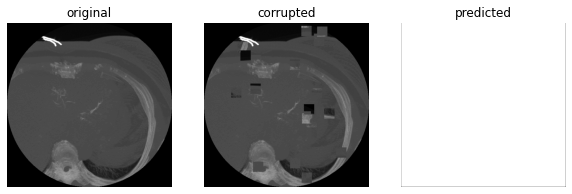

Epoch 2/500
51/51 [==============================] - 17s 330ms/step - loss: 0.0332 - val_loss: 0.0236
Epoch 3/500
51/51 [==============================] - 17s 330ms/step - loss: 0.0212 - val_loss: 0.0199
Epoch 4/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0185 - val_loss: 0.0053
Epoch 5/500
51/51 [==============================] - 17s 331ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 6/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0026 - val_loss: 0.0022


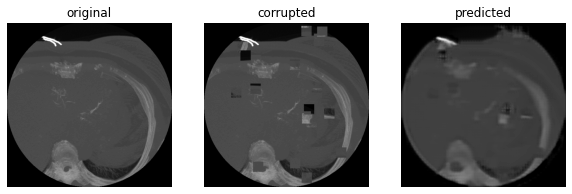

Epoch 7/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/500
51/51 [==============================] - 17s 334ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/500
51/51 [==============================] - 17s 333ms/step - loss: 0.0011 - val_loss: 0.0011


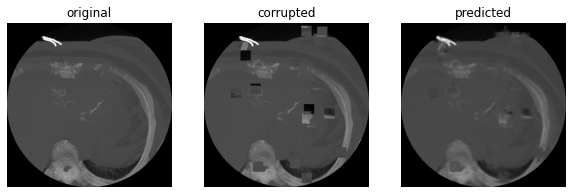

Epoch 12/500
51/51 [==============================] - 17s 332ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 13/500
51/51 [==============================] - 17s 332ms/step - loss: 9.4271e-04 - val_loss: 0.0010
Epoch 14/500
51/51 [==============================] - 17s 333ms/step - loss: 9.1186e-04 - val_loss: 0.0012
Epoch 15/500
51/51 [==============================] - 17s 332ms/step - loss: 9.3856e-04 - val_loss: 9.3221e-04
Epoch 16/500
51/51 [==============================] - 17s 331ms/step - loss: 8.2308e-04 - val_loss: 8.7415e-04


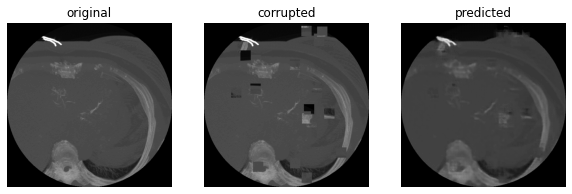

Epoch 17/500
51/51 [==============================] - 17s 332ms/step - loss: 7.6555e-04 - val_loss: 8.2303e-04
Epoch 18/500
51/51 [==============================] - 17s 332ms/step - loss: 7.2302e-04 - val_loss: 8.3510e-04
Epoch 19/500
51/51 [==============================] - 17s 332ms/step - loss: 7.0878e-04 - val_loss: 8.2008e-04
Epoch 20/500
51/51 [==============================] - 17s 332ms/step - loss: 6.7898e-04 - val_loss: 8.3198e-04
Epoch 21/500
51/51 [==============================] - 17s 332ms/step - loss: 7.0650e-04 - val_loss: 7.3214e-04


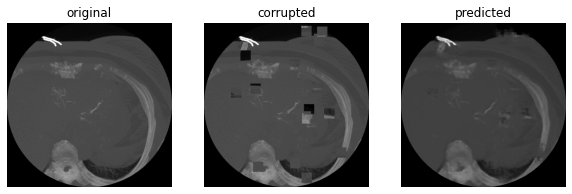

Epoch 22/500
51/51 [==============================] - 17s 332ms/step - loss: 6.0788e-04 - val_loss: 7.2869e-04
Epoch 23/500
51/51 [==============================] - 17s 332ms/step - loss: 5.9485e-04 - val_loss: 8.2180e-04
Epoch 24/500
51/51 [==============================] - 17s 332ms/step - loss: 6.2058e-04 - val_loss: 7.2378e-04
Epoch 25/500
51/51 [==============================] - 17s 332ms/step - loss: 5.5857e-04 - val_loss: 7.2262e-04
Epoch 26/500
51/51 [==============================] - 17s 335ms/step - loss: 5.3864e-04 - val_loss: 7.1929e-04


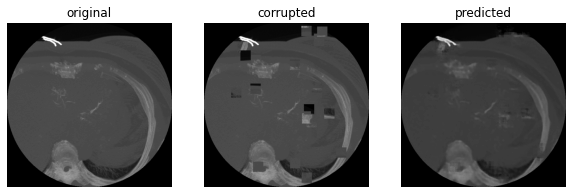

Epoch 27/500
51/51 [==============================] - 17s 333ms/step - loss: 5.1435e-04 - val_loss: 7.3196e-04
Epoch 28/500
51/51 [==============================] - 17s 332ms/step - loss: 5.3723e-04 - val_loss: 6.6644e-04
Epoch 29/500
51/51 [==============================] - 17s 332ms/step - loss: 4.8496e-04 - val_loss: 6.8537e-04
Epoch 30/500
51/51 [==============================] - 17s 332ms/step - loss: 4.7633e-04 - val_loss: 7.1403e-04
Epoch 31/500
51/51 [==============================] - 17s 332ms/step - loss: 4.5984e-04 - val_loss: 6.4138e-04


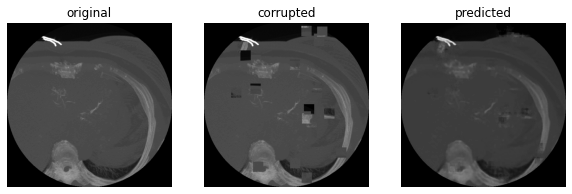

Epoch 32/500
51/51 [==============================] - 17s 333ms/step - loss: 4.5092e-04 - val_loss: 6.6561e-04
Epoch 33/500
51/51 [==============================] - 17s 333ms/step - loss: 4.3911e-04 - val_loss: 6.4890e-04
Epoch 34/500
51/51 [==============================] - 17s 332ms/step - loss: 4.4146e-04 - val_loss: 6.3460e-04
Epoch 35/500
51/51 [==============================] - 17s 332ms/step - loss: 4.0966e-04 - val_loss: 6.1805e-04
Epoch 36/500
51/51 [==============================] - 17s 332ms/step - loss: 4.8128e-04 - val_loss: 6.3981e-04


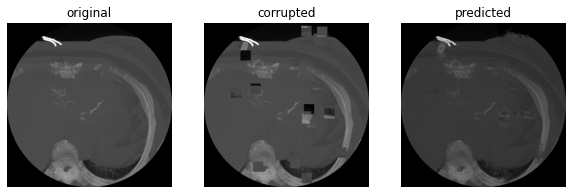

Epoch 37/500
51/51 [==============================] - 17s 333ms/step - loss: 4.0090e-04 - val_loss: 6.1601e-04
Epoch 38/500
51/51 [==============================] - 17s 332ms/step - loss: 3.7962e-04 - val_loss: 6.2431e-04
Epoch 39/500
51/51 [==============================] - 17s 332ms/step - loss: 3.7598e-04 - val_loss: 6.1436e-04
Epoch 40/500
51/51 [==============================] - 17s 332ms/step - loss: 3.5801e-04 - val_loss: 6.0091e-04
Epoch 41/500
51/51 [==============================] - 17s 332ms/step - loss: 3.5604e-04 - val_loss: 6.0875e-04


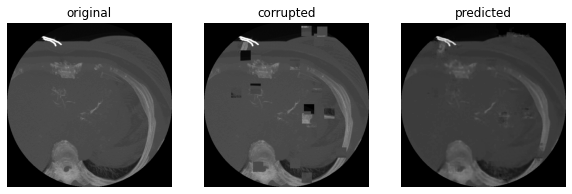

Epoch 42/500
51/51 [==============================] - 17s 332ms/step - loss: 3.4441e-04 - val_loss: 6.0165e-04
Epoch 43/500
51/51 [==============================] - 17s 333ms/step - loss: 3.4413e-04 - val_loss: 5.9857e-04
Epoch 44/500
51/51 [==============================] - 17s 331ms/step - loss: 3.5313e-04 - val_loss: 6.0377e-04
Epoch 45/500
51/51 [==============================] - 17s 333ms/step - loss: 3.3948e-04 - val_loss: 6.1644e-04
Epoch 46/500
51/51 [==============================] - 17s 332ms/step - loss: 4.1848e-04 - val_loss: 6.0915e-04


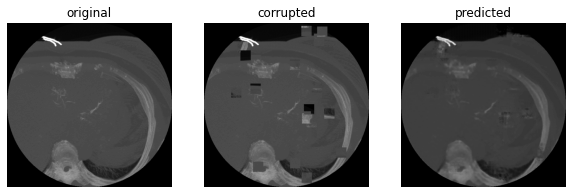

Epoch 47/500
51/51 [==============================] - 17s 332ms/step - loss: 3.4073e-04 - val_loss: 5.9457e-04
Epoch 48/500
51/51 [==============================] - 17s 332ms/step - loss: 3.1737e-04 - val_loss: 5.7168e-04
Epoch 49/500
51/51 [==============================] - 17s 332ms/step - loss: 3.0847e-04 - val_loss: 5.7009e-04
Epoch 50/500
51/51 [==============================] - 17s 332ms/step - loss: 3.0010e-04 - val_loss: 5.8624e-04
Epoch 51/500
51/51 [==============================] - 17s 333ms/step - loss: 3.0259e-04 - val_loss: 5.9112e-04


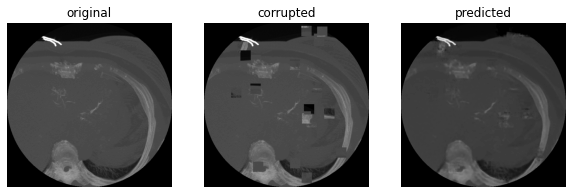

Epoch 52/500
51/51 [==============================] - 17s 332ms/step - loss: 3.0139e-04 - val_loss: 5.7748e-04
Epoch 53/500
51/51 [==============================] - 17s 332ms/step - loss: 2.8583e-04 - val_loss: 5.6402e-04
Epoch 54/500
51/51 [==============================] - 17s 332ms/step - loss: 2.9107e-04 - val_loss: 0.0011
Epoch 55/500
51/51 [==============================] - 17s 332ms/step - loss: 7.0228e-04 - val_loss: 6.7584e-04
Epoch 56/500
51/51 [==============================] - 17s 331ms/step - loss: 3.7714e-04 - val_loss: 6.0008e-04


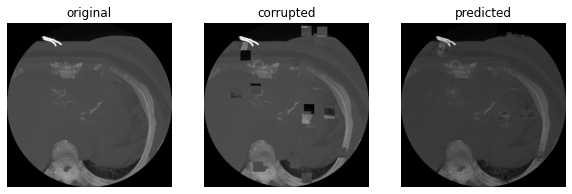

Epoch 57/500
51/51 [==============================] - 17s 332ms/step - loss: 3.0331e-04 - val_loss: 5.5229e-04
Epoch 58/500
51/51 [==============================] - 17s 332ms/step - loss: 2.7700e-04 - val_loss: 5.5782e-04
Epoch 59/500
51/51 [==============================] - 17s 332ms/step - loss: 2.6954e-04 - val_loss: 5.6220e-04
Epoch 60/500
51/51 [==============================] - 17s 331ms/step - loss: 2.8453e-04 - val_loss: 5.5505e-04
Epoch 61/500
51/51 [==============================] - 17s 332ms/step - loss: 2.5931e-04 - val_loss: 5.5517e-04


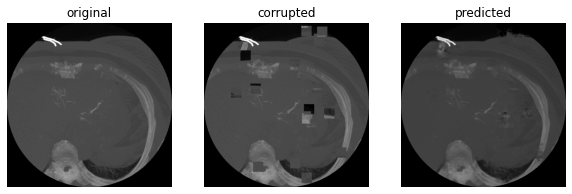

Epoch 62/500
51/51 [==============================] - 17s 332ms/step - loss: 2.5983e-04 - val_loss: 5.6751e-04
Epoch 63/500
51/51 [==============================] - 17s 332ms/step - loss: 2.5770e-04 - val_loss: 6.0933e-04
Epoch 64/500
51/51 [==============================] - 17s 332ms/step - loss: 3.4251e-04 - val_loss: 5.6976e-04
Epoch 65/500
51/51 [==============================] - 17s 332ms/step - loss: 2.6336e-04 - val_loss: 5.5279e-04
Epoch 66/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4818e-04 - val_loss: 5.5394e-04


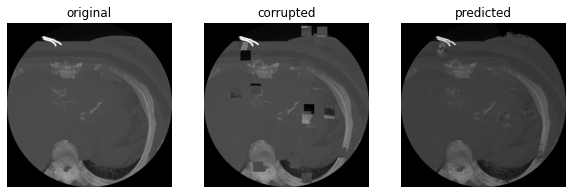

Epoch 67/500
51/51 [==============================] - 17s 332ms/step - loss: 2.4081e-04 - val_loss: 5.4123e-04
Epoch 68/500
51/51 [==============================] - 17s 332ms/step - loss: 2.3721e-04 - val_loss: 5.4843e-04
Epoch 69/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4154e-04 - val_loss: 5.3827e-04
Epoch 70/500
51/51 [==============================] - 17s 332ms/step - loss: 2.3315e-04 - val_loss: 5.4253e-04
Epoch 71/500
51/51 [==============================] - 17s 332ms/step - loss: 2.5102e-04 - val_loss: 5.7732e-04


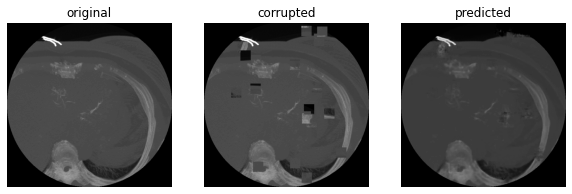

Epoch 72/500
51/51 [==============================] - 17s 333ms/step - loss: 7.2187e-04 - val_loss: 6.9618e-04
Epoch 73/500
51/51 [==============================] - 17s 333ms/step - loss: 3.7183e-04 - val_loss: 5.6416e-04
Epoch 74/500
51/51 [==============================] - 17s 333ms/step - loss: 2.8781e-04 - val_loss: 5.3405e-04
Epoch 75/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4793e-04 - val_loss: 5.2994e-04
Epoch 76/500
51/51 [==============================] - 17s 336ms/step - loss: 2.3531e-04 - val_loss: 5.2087e-04


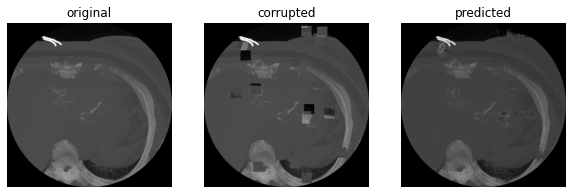

Epoch 77/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2660e-04 - val_loss: 5.2312e-04
Epoch 78/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2249e-04 - val_loss: 5.3037e-04
Epoch 79/500
51/51 [==============================] - 17s 333ms/step - loss: 2.1921e-04 - val_loss: 5.3040e-04
Epoch 80/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2111e-04 - val_loss: 5.2933e-04
Epoch 81/500
51/51 [==============================] - 17s 334ms/step - loss: 2.1413e-04 - val_loss: 5.2694e-04


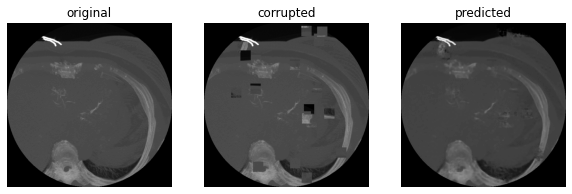

Epoch 82/500
51/51 [==============================] - 17s 333ms/step - loss: 2.1454e-04 - val_loss: 5.2259e-04
Epoch 83/500
51/51 [==============================] - 17s 332ms/step - loss: 2.1523e-04 - val_loss: 5.3939e-04
Epoch 84/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2114e-04 - val_loss: 5.3509e-04
Epoch 85/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2177e-04 - val_loss: 5.3362e-04
Epoch 86/500
51/51 [==============================] - 17s 333ms/step - loss: 2.1445e-04 - val_loss: 5.2180e-04


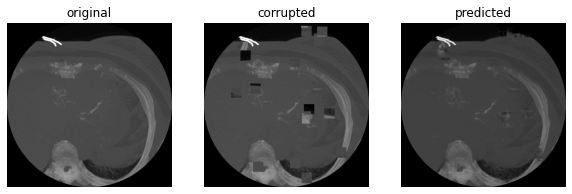

Epoch 87/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0584e-04 - val_loss: 5.2183e-04
Epoch 88/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0715e-04 - val_loss: 5.1847e-04
Epoch 89/500
51/51 [==============================] - 17s 333ms/step - loss: 4.4235e-04 - val_loss: 0.0011
Epoch 90/500
51/51 [==============================] - 17s 333ms/step - loss: 5.4518e-04 - val_loss: 6.3277e-04
Epoch 91/500
51/51 [==============================] - 17s 333ms/step - loss: 2.6921e-04 - val_loss: 5.3123e-04


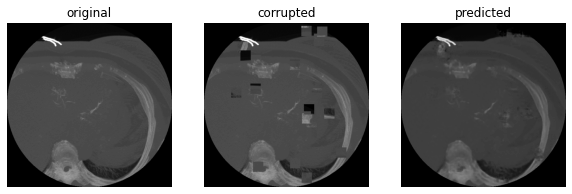

Epoch 92/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2336e-04 - val_loss: 5.2702e-04
Epoch 93/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0580e-04 - val_loss: 5.1875e-04
Epoch 94/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0058e-04 - val_loss: 5.2153e-04
Epoch 95/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9759e-04 - val_loss: 5.0844e-04
Epoch 96/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9152e-04 - val_loss: 5.1010e-04


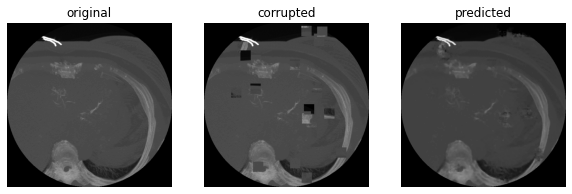

Epoch 97/500
51/51 [==============================] - 17s 332ms/step - loss: 1.8955e-04 - val_loss: 5.1095e-04
Epoch 98/500
51/51 [==============================] - 17s 333ms/step - loss: 1.8901e-04 - val_loss: 5.1151e-04
Epoch 99/500
51/51 [==============================] - 17s 332ms/step - loss: 1.8645e-04 - val_loss: 5.1059e-04
Epoch 100/500
51/51 [==============================] - 17s 332ms/step - loss: 1.9527e-04 - val_loss: 5.1082e-04
Epoch 101/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9474e-04 - val_loss: 5.2104e-04


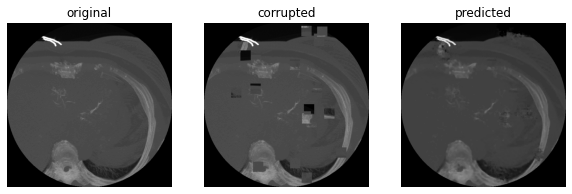

Epoch 102/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9366e-04 - val_loss: 5.5914e-04
Epoch 103/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9912e-04 - val_loss: 5.1108e-04
Epoch 104/500
51/51 [==============================] - 17s 332ms/step - loss: 1.8515e-04 - val_loss: 5.1299e-04
Epoch 105/500
51/51 [==============================] - 17s 333ms/step - loss: 1.8271e-04 - val_loss: 5.1758e-04
Epoch 106/500
51/51 [==============================] - 17s 333ms/step - loss: 2.3500e-04 - val_loss: 6.9573e-04


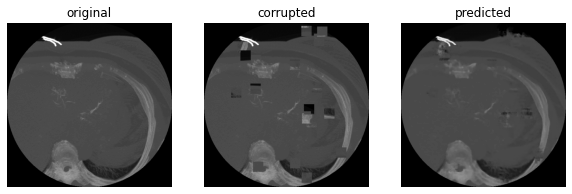

Epoch 107/500
51/51 [==============================] - 17s 333ms/step - loss: 3.0941e-04 - val_loss: 5.5341e-04
Epoch 108/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2268e-04 - val_loss: 5.2459e-04
Epoch 109/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9910e-04 - val_loss: 5.0039e-04
Epoch 110/500
51/51 [==============================] - 17s 333ms/step - loss: 1.8183e-04 - val_loss: 5.0882e-04
Epoch 111/500
51/51 [==============================] - 17s 333ms/step - loss: 1.7800e-04 - val_loss: 5.0324e-04


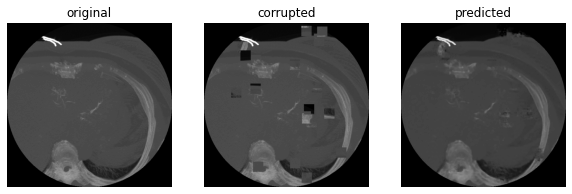

Epoch 112/500
51/51 [==============================] - 17s 333ms/step - loss: 1.9272e-04 - val_loss: 5.4115e-04
Epoch 113/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4820e-04 - val_loss: 5.5116e-04
Epoch 114/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0418e-04 - val_loss: 5.5117e-04
Epoch 115/500
51/51 [==============================] - 17s 334ms/step - loss: 1.9224e-04 - val_loss: 5.0642e-04
Epoch 116/500
51/51 [==============================] - 17s 333ms/step - loss: 2.7044e-04 - val_loss: 5.2587e-04


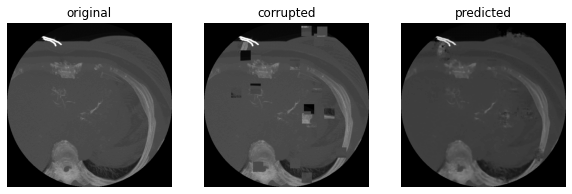

Epoch 117/500
51/51 [==============================] - 17s 334ms/step - loss: 1.8758e-04 - val_loss: 5.0146e-04
Epoch 118/500
51/51 [==============================] - 17s 333ms/step - loss: 1.7303e-04 - val_loss: 4.9473e-04
Epoch 119/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6958e-04 - val_loss: 5.0714e-04
Epoch 120/500
51/51 [==============================] - 17s 332ms/step - loss: 1.6714e-04 - val_loss: 4.9268e-04
Epoch 121/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6273e-04 - val_loss: 4.9706e-04


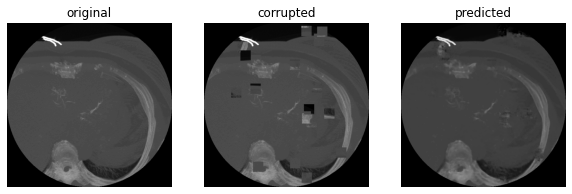

Epoch 122/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6311e-04 - val_loss: 5.0140e-04
Epoch 123/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6254e-04 - val_loss: 4.9815e-04
Epoch 124/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6699e-04 - val_loss: 5.1414e-04
Epoch 125/500
51/51 [==============================] - 17s 333ms/step - loss: 1.7547e-04 - val_loss: 5.0111e-04
Epoch 126/500
51/51 [==============================] - 17s 336ms/step - loss: 1.7220e-04 - val_loss: 5.0207e-04


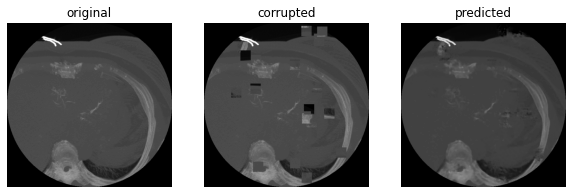

Epoch 127/500
51/51 [==============================] - 17s 333ms/step - loss: 2.5928e-04 - val_loss: 5.3370e-04
Epoch 128/500
51/51 [==============================] - 17s 333ms/step - loss: 2.3959e-04 - val_loss: 5.1449e-04
Epoch 129/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2031e-04 - val_loss: 5.1351e-04
Epoch 130/500
51/51 [==============================] - 17s 333ms/step - loss: 1.7642e-04 - val_loss: 4.9449e-04
Epoch 131/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6349e-04 - val_loss: 4.9059e-04


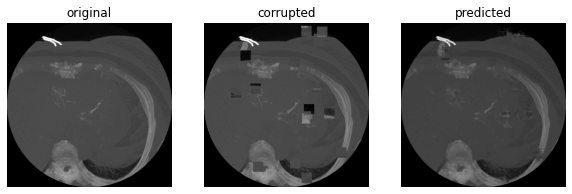

Epoch 132/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6052e-04 - val_loss: 4.8692e-04
Epoch 133/500
51/51 [==============================] - 17s 334ms/step - loss: 1.5691e-04 - val_loss: 4.8865e-04
Epoch 134/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5565e-04 - val_loss: 4.9060e-04
Epoch 135/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5358e-04 - val_loss: 4.8886e-04
Epoch 136/500
51/51 [==============================] - 17s 334ms/step - loss: 1.6723e-04 - val_loss: 5.2076e-04


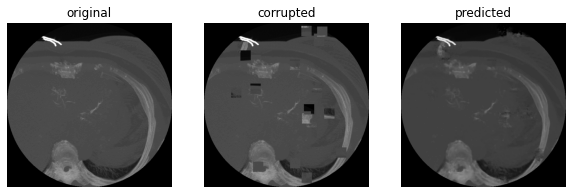

Epoch 137/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6840e-04 - val_loss: 4.9358e-04
Epoch 138/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6098e-04 - val_loss: 5.1834e-04
Epoch 139/500
51/51 [==============================] - 17s 332ms/step - loss: 1.7078e-04 - val_loss: 4.9594e-04
Epoch 140/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6347e-04 - val_loss: 4.9111e-04
Epoch 141/500
51/51 [==============================] - 17s 334ms/step - loss: 1.5666e-04 - val_loss: 5.1518e-04


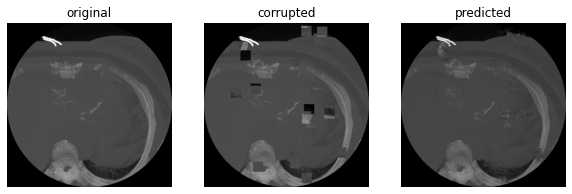

Epoch 142/500
51/51 [==============================] - 17s 333ms/step - loss: 3.8762e-04 - val_loss: 5.8586e-04
Epoch 143/500
51/51 [==============================] - 17s 333ms/step - loss: 2.4598e-04 - val_loss: 5.0770e-04
Epoch 144/500
51/51 [==============================] - 17s 333ms/step - loss: 1.8350e-04 - val_loss: 4.8578e-04
Epoch 145/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6610e-04 - val_loss: 4.8890e-04
Epoch 146/500
51/51 [==============================] - 17s 332ms/step - loss: 2.2808e-04 - val_loss: 4.9950e-04


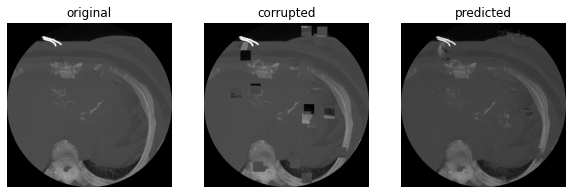

Epoch 147/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6749e-04 - val_loss: 4.8033e-04
Epoch 148/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5461e-04 - val_loss: 4.8242e-04
Epoch 149/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5377e-04 - val_loss: 4.8076e-04
Epoch 150/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4869e-04 - val_loss: 4.9149e-04
Epoch 151/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4760e-04 - val_loss: 4.8219e-04


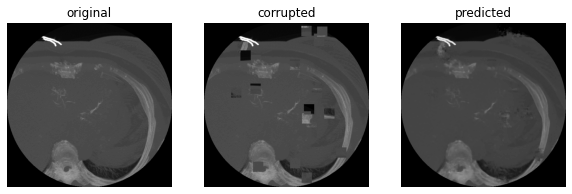

Epoch 152/500
51/51 [==============================] - 17s 334ms/step - loss: 1.4658e-04 - val_loss: 4.8181e-04
Epoch 153/500
51/51 [==============================] - 17s 333ms/step - loss: 1.6156e-04 - val_loss: 4.8457e-04
Epoch 154/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4682e-04 - val_loss: 4.8136e-04
Epoch 155/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4845e-04 - val_loss: 4.8998e-04
Epoch 156/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4908e-04 - val_loss: 4.9575e-04


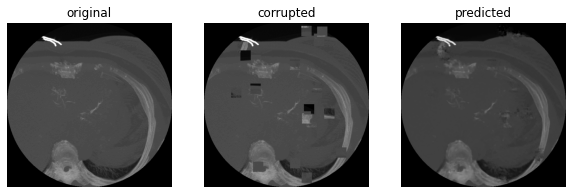

Epoch 157/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4878e-04 - val_loss: 4.8974e-04
Epoch 158/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5729e-04 - val_loss: 5.0350e-04
Epoch 159/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5512e-04 - val_loss: 4.8499e-04
Epoch 160/500
51/51 [==============================] - 17s 334ms/step - loss: 1.5106e-04 - val_loss: 4.8979e-04
Epoch 161/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4298e-04 - val_loss: 4.8035e-04


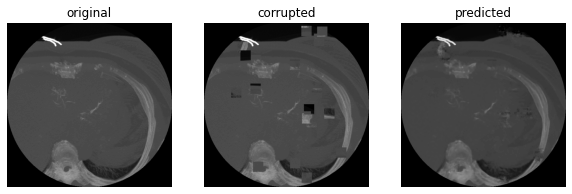

Epoch 162/500
51/51 [==============================] - 17s 332ms/step - loss: 2.3671e-04 - val_loss: 7.6656e-04
Epoch 163/500
51/51 [==============================] - 17s 333ms/step - loss: 3.1044e-04 - val_loss: 5.3473e-04
Epoch 164/500
51/51 [==============================] - 17s 333ms/step - loss: 2.0818e-04 - val_loss: 4.9058e-04
Epoch 165/500
51/51 [==============================] - 17s 332ms/step - loss: 1.6640e-04 - val_loss: 4.7610e-04
Epoch 166/500
51/51 [==============================] - 17s 332ms/step - loss: 1.5258e-04 - val_loss: 4.7237e-04


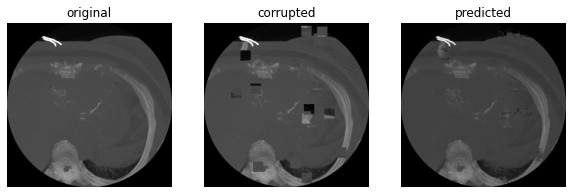

Epoch 167/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4222e-04 - val_loss: 4.7191e-04
Epoch 168/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4490e-04 - val_loss: 4.7815e-04
Epoch 169/500
51/51 [==============================] - 17s 333ms/step - loss: 1.3828e-04 - val_loss: 4.8137e-04
Epoch 170/500
51/51 [==============================] - 17s 332ms/step - loss: 1.3826e-04 - val_loss: 4.7295e-04
Epoch 171/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4594e-04 - val_loss: 4.8634e-04


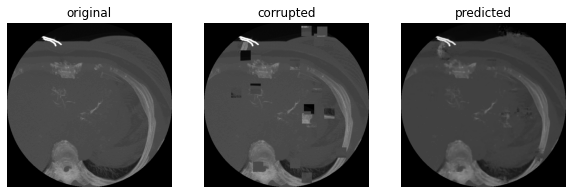

Epoch 172/500
51/51 [==============================] - 17s 332ms/step - loss: 2.6014e-04 - val_loss: 5.2111e-04
Epoch 173/500
51/51 [==============================] - 17s 332ms/step - loss: 1.6546e-04 - val_loss: 5.0279e-04
Epoch 174/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4635e-04 - val_loss: 4.6825e-04
Epoch 175/500
51/51 [==============================] - 17s 333ms/step - loss: 1.3498e-04 - val_loss: 4.6790e-04
Epoch 176/500
51/51 [==============================] - 17s 336ms/step - loss: 1.3300e-04 - val_loss: 4.7268e-04


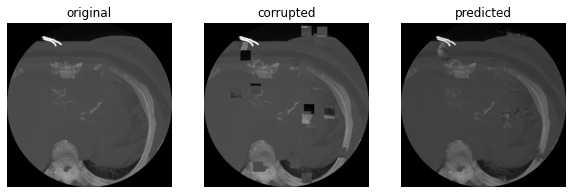

Epoch 177/500
51/51 [==============================] - 17s 333ms/step - loss: 1.3153e-04 - val_loss: 4.7051e-04
Epoch 178/500
51/51 [==============================] - 17s 333ms/step - loss: 1.2906e-04 - val_loss: 4.7142e-04
Epoch 179/500
51/51 [==============================] - 17s 333ms/step - loss: 1.3065e-04 - val_loss: 4.6938e-04
Epoch 180/500
51/51 [==============================] - 17s 333ms/step - loss: 1.5297e-04 - val_loss: 5.3717e-04
Epoch 181/500
51/51 [==============================] - 17s 333ms/step - loss: 1.4944e-04 - val_loss: 4.7728e-04


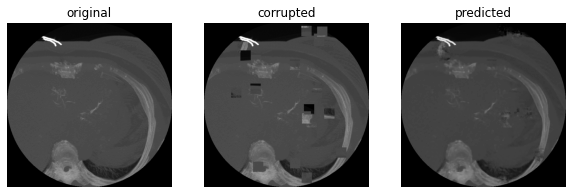

Epoch 182/500
51/51 [==============================] - 17s 333ms/step - loss: 1.3706e-04 - val_loss: 4.9989e-04
Epoch 183/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4253e-04 - val_loss: 4.7308e-04
Epoch 184/500
51/51 [==============================] - 17s 332ms/step - loss: 1.4171e-04 - val_loss: 4.8715e-04
Epoch 185/500
51/51 [==============================] - 17s 333ms/step - loss: 1.7738e-04 - val_loss: 7.8327e-04
Epoch 186/500
51/51 [==============================] - 17s 333ms/step - loss: 2.2299e-04 - val_loss: 4.8901e-04


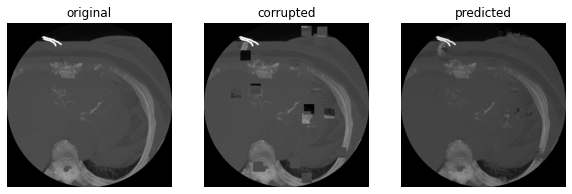

Epoch 187/500
13/51 [======>.......................] - ETA: 11s - loss: 1.5016e-04

KeyboardInterrupt: 

In [11]:
history = model.fit(X_train, y_train, epochs=500, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [12]:
modelName = 'models/' + MODEL_NAME
model.save(modelName)

INFO:tensorflow:Assets written to: models/medium_model_LR_0.001_3/assets


## Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
exclude=['models/medium_model_LR_0.001_2/image.png','models/medium_model_LR_0.001_2/image_corrupt.png']
reconstructed = glob('models/medium_model_LR_0.001_2/*.png')
reconstructed = [r for r in reconstructed if r not in exclude]
reconstructed.sort()

images = []
for image_path in reconstructed:
    im = plt.imread(image_path)
    images.append(plt.imread(image_path))
images = np.array(images)
reconstructed

In [ ]:
%%time

Figure = plt.figure()
 
# creating a plot
lines_plotted = plt.imshow(images[0], cmap=plt.cm.gray)    

# function takes frame as an input
def AnimationFunction(frame):
 
    # setting y according to frame
    # number and + x. It's logic
    plt.imshow(images[frame], cmap=plt.cm.gray)
     
anim = FuncAnimation(Figure, AnimationFunction, frames=images.shape[0], interval=100)

writervideo = animation.FFMpegWriter(fps=10)
# anim.save('videos/TrainingsVideo.mp4', writervideo)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()